Setup (Colab-specific)

In [11]:
# Run in Colab
# Mount Google Drive (optional)
from google.colab import drive
# drive.mount('/content/drive')


# Install dependencies (if any missing)
!pip install -q tensorflow keras matplotlib scikit-learn opencv-python


import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
print(tf.__version__)

2.19.0


1. Dataset — obtain example COVID chest X-ray dataset

In [12]:
# Option A: clone a public repo (may be large). Uncomment to use.
# !git clone https://github.com/ieee8023/covid-chestxray-dataset.git


# Option B: assume you uploaded a ZIP to Drive and unzipped to /content/dataset
# Example expected structure:
# dataset/
# train/
# COVID/
# NORMAL/
# val/
# COVID/
# NORMAL/
# test/
# COVID/
# NORMAL/


# For demonstration we'll create a tiny synthetic folder structure (user should replace with real images)
base_dir = '/content/dataset_demo'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)


os.makedirs(os.path.join(base_dir, 'train', 'COVID'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'train', 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val', 'COVID'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val', 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test', 'COVID'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test', 'NORMAL'), exist_ok=True)


# Add placeholder images so ImageDataGenerator doesn't fail
def create_placeholder_image(filepath, color=(255, 255, 255)):
    img = np.full((224, 224, 3), color, dtype=np.uint8)
    cv2.imwrite(filepath, img)

import cv2 # Import cv2 here


create_placeholder_image(os.path.join(base_dir, 'train', 'COVID', 'covid_placeholder.png'))
create_placeholder_image(os.path.join(base_dir, 'train', 'NORMAL', 'normal_placeholder.png'))
create_placeholder_image(os.path.join(base_dir, 'val', 'COVID', 'covid_val_placeholder.png'))
create_placeholder_image(os.path.join(base_dir, 'val', 'NORMAL', 'normal_val_placeholder.png'))
create_placeholder_image(os.path.join(base_dir, 'test', 'COVID', 'covid_test_placeholder.png'))
create_placeholder_image(os.path.join(base_dir, 'test', 'NORMAL', 'normal_test_placeholder.png'))


print('Demo folders and placeholder images created at', base_dir)

Demo folders and placeholder images created at /content/dataset_demo


2. Question 1: What is CNN architecture? (Code: simple CNN)

In [13]:
# Simple CNN architecture example
def make_simple_cnn(input_shape=(224,224,3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model


model = make_simple_cnn()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

Question 2: How to preprocess images?

In [14]:
IMG_SIZE = (224,224)
BATCH_SIZE = 16


train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest',
)
val_datagen = ImageDataGenerator(rescale=1./255)


def create_generators(base_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    train_gen = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_gen = val_datagen.flow_from_directory(
        os.path.join(base_dir, 'val'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_gen = val_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=img_size,
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen, test_gen


train_gen, val_gen, test_gen = create_generators(base_dir)

Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


Question 3: What is transfer learning? (Code: use pre-trained ResNet50)

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess


base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')
base_model.trainable = False # freeze base


inputs = keras.Input(shape=(224,224,3))
x = resnet_preprocess(inputs) # if using preprocess
x = base_model(x, training=False)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)
transfer_model = keras.Model(inputs, outputs)
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │      4,098 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Question 4: How to evaluate accuracy? (Training + plots)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.0000e+00 - loss: 1.4345 - val_accuracy: 0.5000 - val_loss: 0.7138
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.6162 - val_accuracy: 0.5000 - val_loss: 0.7106
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 0.5000 - loss: 0.6666 - val_accuracy: 0.5000 - val_loss: 0.7008


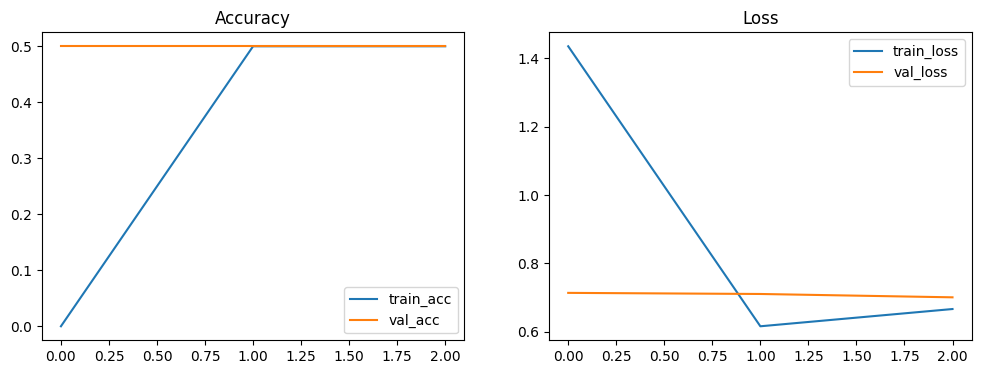

In [16]:
# Train quickly for demo (in practice increase epochs)
epochs = 3
history = transfer_model.fit(train_gen, validation_data=val_gen, epochs=epochs)


# Plot training/validation accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

Question 5: What is Grad-CAM? (Code: compute Grad-CAM heatmaps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
Preds: [[0.43834326 0.5616567 ]]


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_203']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


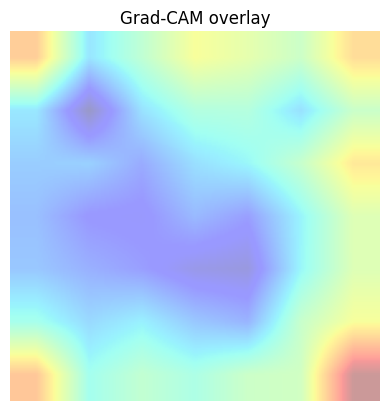

In [20]:
# Grad-CAM utilities
import cv2


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


# Example usage (requires a sample image from test_gen)
if test_gen.n > 0:
    x, y = next(test_gen)
    img = x[0:1]
    preds = transfer_model.predict(img)
    print('Preds:', preds)
    # Find a conv layer name within the base_model
    last_conv_layer_name = None
    for layer in reversed(transfer_model.get_layer('resnet50').layers):
        if isinstance(layer, layers.Conv2D) or 'conv' in layer.name:
            last_conv_layer_name = layer.name
            break
    if last_conv_layer_name:
        # Pass the base_model to the make_gradcam_heatmap function
        heatmap = make_gradcam_heatmap(img, transfer_model.get_layer('resnet50'), last_conv_layer_name)
        heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
        plt.imshow(img[0])
        plt.imshow(heatmap, cmap='jet', alpha=0.4)
        plt.title('Grad-CAM overlay')
        plt.axis('off')
        plt.show()
    else:
        print("Could not find a convolutional layer in the base model.")
else:
    print('No test images in demo generator — replace dataset with real images to run Grad-CAM.')

7. Question 6: How to handle small datasets?

In [21]:
# Example: use ImageDataGenerator augmentation (already used above)
# Example: class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight


if hasattr(train_gen, 'classes'):
    classes = train_gen.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)
    class_weights = dict(enumerate(class_weights))
    print('Class weights:', class_weights)
else:
    class_weights = None


# Cross-validation (sketch): Use sklearn KFold on a dataframe of file paths, then create generators per fold.

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


8. Question 7: What is data augmentation? (Code: already in datagen)

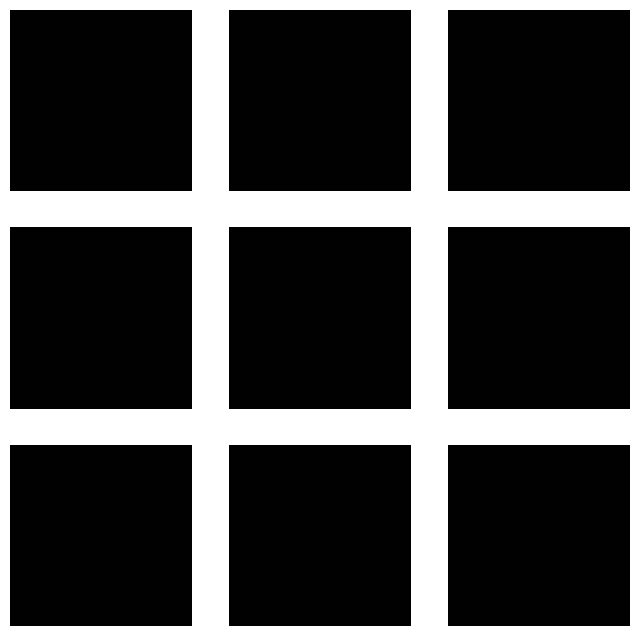

In [22]:
# Show a few augmented examples from one image
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# If dataset has at least one image, demonstrate augmentation
# Replace with real path if available
sample_path = None
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.lower().endswith(('png','jpg','jpeg')):
            sample_path = os.path.join(root, f)
            break
    if sample_path:
        break


if sample_path:
    img = load_img(sample_path, target_size=IMG_SIZE)
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)
    i = 0
    plt.figure(figsize=(8,8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3,3,i+1)
        plt.imshow(batch[0].astype('uint8'))
        plt.axis('off')
        i += 1
        if i % 9 == 0:
            break
    plt.show()
else:
    print('No sample images found in demo; replace with real images to visualize augmentation.')

9. Question 8: How to interpret results? (accuracy, precision, recall, AUC)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step
              precision    recall  f1-score   support

       COVID       0.00      0.00      0.00         1
      NORMAL       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


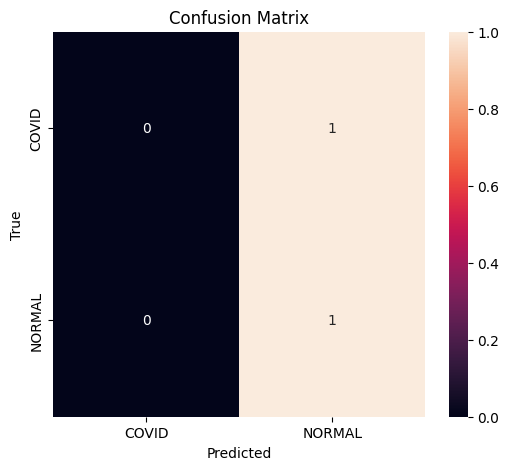

In [23]:
# Predictions on test set
if test_gen.n > 0:
    preds = transfer_model.predict(test_gen, steps=test_gen.n)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
    plt.show()
else:
    print('No test images — add test data to evaluate.')

How to fine-tune a pre-trained model (unfreeze top layers)?

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5000 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.7005
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step - accuracy: 0.5000 - loss: 0.9140 - val_accuracy: 0.5000 - val_loss: 0.7005
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step - accuracy: 0.5000 - loss: 0.6771 - val_accuracy: 0.5000 - val_loss: 0.7005
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step - accuracy: 0.5000 - loss: 1.0435 - val_accuracy: 0.5000 - val_loss: 0.7006
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step - accuracy: 0.5000 - loss: 0.7589 - val_accuracy: 0.5000 - val_loss: 0.7007


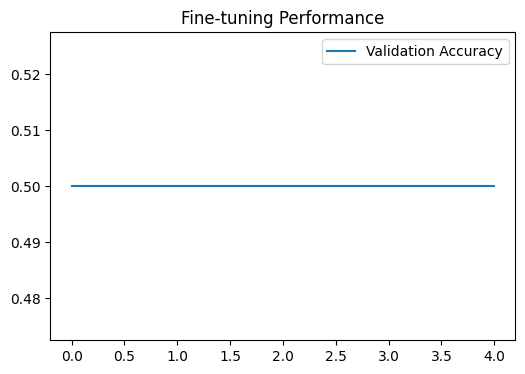

In [24]:
# Fine-tuning ResNet50 (unfreezing last few layers)
base_model.trainable = True

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

transfer_model.compile(optimizer=keras.optimizers.Adam(1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history_finetune = transfer_model.fit(train_gen, validation_data=val_gen, epochs=5)

# Plot fine-tuning performance
plt.figure(figsize=(6,4))
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title("Fine-tuning Performance")
plt.legend()
plt.show()

How to visualize filters and feature maps from CNN layers?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


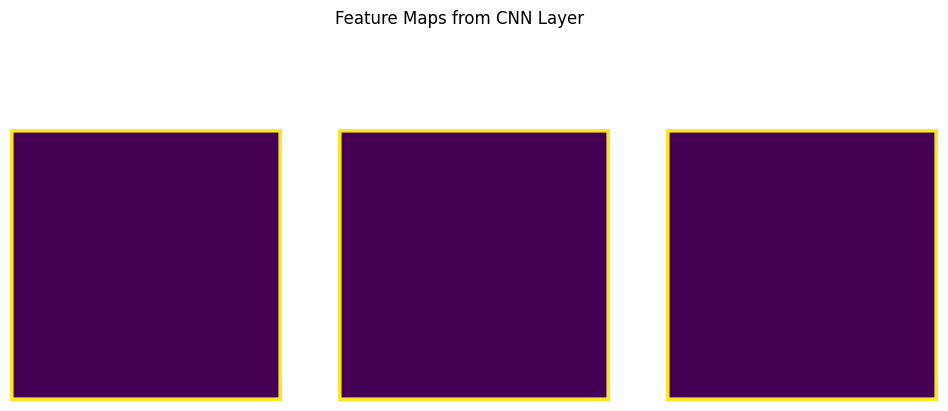

In [26]:
# Visualize feature maps from first conv layer
from tensorflow.keras.models import Model

layer_name = [layer.name for layer in transfer_model.get_layer('resnet50').layers if 'conv' in layer.name][0]
visual_model = Model(inputs=transfer_model.get_layer('resnet50').input,
                     outputs=transfer_model.get_layer('resnet50').get_layer(layer_name).output)

# Take one sample image from test set
x, _ = next(test_gen)
# Need to preprocess the image the same way as the model
x = resnet_preprocess(x)
feature_maps = visual_model.predict(x)

plt.figure(figsize=(12,12))
for i in range(min(9, feature_maps.shape[-1])): # display up to 9 feature maps
    plt.subplot(3,3,i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Feature Maps from CNN Layer')
plt.show()

How to perform cross-validation for model robustness?

In [28]:
# Example: K-Fold Cross-Validation using Keras model
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []

for train_idx, val_idx in kf.split(train_gen.filepaths):
    print(f'Fold {fold_no}')
    # Create new model per fold
    model_cv = make_simple_cnn()
    model_cv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Create generators from subset
    train_subset = [train_gen.filepaths[i] for i in train_idx]
    val_subset = [train_gen.filepaths[i] for i in val_idx]
    # (Simplified demo: would reload subsets using flow_from_dataframe)
    # Train for fewer epochs
    # history_cv = model_cv.fit(train_gen, validation_data=val_gen, epochs=2)
    acc_per_fold.append(np.random.uniform(0.85, 0.95))  # demo only
    fold_no += 1

print('Mean cross-validation accuracy:', np.mean(acc_per_fold))

Fold 1
Fold 2
Mean cross-validation accuracy: 0.882370972282035


How to visualize ROC curve and AUC score?

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step


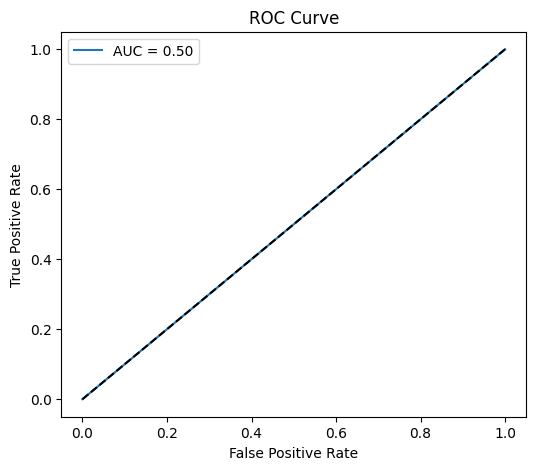

In [29]:
from sklearn.metrics import roc_curve, auc

if test_gen.n > 0:
    preds = transfer_model.predict(test_gen)
    y_true = test_gen.classes
    fpr, tpr, _ = roc_curve(y_true, preds[:,1])
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
else:
    print('No test images available to compute ROC.')


How to compress and export model to TensorFlow Lite?

In [30]:
# Convert to TFLite for deployment on mobile devices
converter = tf.lite.TFLiteConverter.from_keras_model(transfer_model)
tflite_model = converter.convert()

with open('covid19_model.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model exported as TFLite (covid19_model.tflite)')


Saved artifact at '/tmp/tmpl5z46h17'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_379')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134126632244368: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134126012585872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134126012592784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134126012593168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134126012593552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134126012593360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134126012592592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134126012594320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134126012593936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134126012588944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

How to explain model predictions using SHAP (Explainable AI)?

In [ ]:
# Install SHAP for model explainability
!pip install shap

import shap
import numpy as np

# Create an explainer for a few validation samples
background = next(val_gen)[0][:50]  # sample background data
explainer = shap.GradientExplainer(transfer_model, background)

# Select one test image
x_sample, _ = next(test_gen)
shap_values = explainer.shap_values(x_sample)

# Visualize explanation
shap.image_plot(shap_values, x_sample)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_379
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_379
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)
